In [1]:
import os
import sys
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn import metrics
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## Import YAMNet
There are two ways of doing this:
* Downloading YAMNet from TensorFlow Hub
* Downloading the full YAMNet repository, and loading in the pre-trained weights (offers customisability with hop length) 

### Option 1: Download from TF Hub

In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

### Option 2: Download YAMNet repo

In [ ]:
# !git clone https://github.com/tensorflow/models.
# !wget https://storage.googleapis.com/audioset/yamnet.h5
yamnet_dir = './models/research/audioset/yamnet/'
sys.path.append(yamnet_dir)
import params as yamnet_params
import yamnet as yamnet
import features as features_lib
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
# test patch size of 0.32, 3 patches per window (96)
params = yamnet_params.Params(patch_hop_seconds=0.32)
og_class_names = yamnet.class_names('./models/research/audioset/yamnet/yamnet_class_map.csv')
yamnet_model  = yamnet.yamnet_frames_model(params)
yamnet_model.load_weights('yamnet.h5')

## Define Utility Functions

In [3]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label
  
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))

## Import training and validation data

In [4]:
# load data from csv
path = 'C:/Users/vanes/OneDrive - Queensland University of Technology/Sem 2 2021/EGH400-2/CV-files/cv-valid-train'
cv_file_csv = path + '/cv_train_main_file.csv'
train_data = pd.read_csv(cv_file_csv)

val_data = pd.read_csv('C:/Users/vanes/OneDrive - Queensland University of Technology/Sem 2 2021/EGH400-2/CV-files/cv-valid-dev/cv_val_main_file.csv')

# add directory paths to file names
train_filenames = train_data['filename']
filepath = path + '/cv-train-mix-chunks/'
train_filenames = [filepath + f for f in train_filenames]
train_targets = train_data['label']

val_filenames = val_data['filename']
val_filepath ='C:/Users/vanes/OneDrive - Queensland University of Technology/Sem 2 2021/EGH400-2/CV-files/cv-valid-dev/cv-dev-mix-chunks/'
val_filenames = [val_filepath + f for f in val_filenames]
val_targets = val_data['label']

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_filenames, train_targets))
val_ds = tf.data.Dataset.from_tensor_slices((val_filenames, val_targets))

# audio file to wav 
train_ds = train_ds.map(load_wav_for_map)
val_ds = val_ds.map(load_wav_for_map)

## Extract YAMNet embeddings to prepare for training
The dataset now contains WAV arrays with labels. Using YAMNet, the embeddings (n, 1024) will be used as features for the new speech detector layer. 

The default hop length is 0.48 seconds, meaning YAMnet will output a set of embeddings for each 0.48 seconds. 

In [6]:
train_ds = train_ds.map(extract_embedding).unbatch()
val_ds = val_ds.map(extract_embedding).unbatch()
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Defining and training the speech detector

In [7]:
my_classes = ['not speech', 'speech']
map_class_to_id = {'not speech':0, 'speech':1}

In [31]:

speech_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, # YAMnet embeddings as input 
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes)) 
], name='speech_model')

speech_model.summary()

Model: "speech_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026      
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [32]:
from tensorflow.keras.optimizers import SGD, Adam, Adamax
#opt = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
opt = Adamax(learning_rate=0.00001)
speech_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=opt,
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [33]:
history = speech_model.fit(train_ds,
                       epochs=300,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/300
190/190 [==============================] - 1s 2ms/step - loss: 0.6950 - accuracy: 0.5316 - val_loss: 0.6741 - val_accuracy: 0.6204
Epoch 2/300
190/190 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.7857 - val_loss: 0.6985 - val_accuracy: 0.5198
Epoch 3/300
190/190 [==============================] - 0s 2ms/step - loss: 0.5353 - accuracy: 0.7849 - val_loss: 0.7137 - val_accuracy: 0.4929
Epoch 4/300
190/190 [==============================] - 0s 2ms/step - loss: 0.5002 - accuracy: 0.7882 - val_loss: 0.7182 - val_accuracy: 0.5127
Epoch 5/300
190/190 [==============================] - 0s 2ms/step - loss: 0.4735 - accuracy: 0.7948 - val_loss: 0.7152 - val_accuracy: 0.5425
Epoch 6/300
190/190 [==============================] - 0s 2ms/step - loss: 0.4518 - accuracy: 0.8030 - val_loss: 0.7032 - val_accuracy: 0.5779
Epoch 7/300
190/190 [==============================] - 0s 2ms/step - loss: 0.4322 - accuracy: 0.8139 - val_loss: 0.6889 - val_accuracy: 0.6289

In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


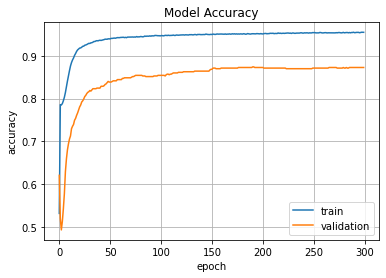

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

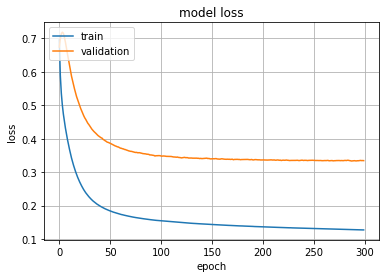

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

In [28]:
test_wav_data = load_wav_16k_mono('C:/Users/vanes/OneDrive - Queensland University of Technology/Sem 2 2021/EGH400-2/MainDriveAudio/Misc/20210916T122828+1000_sensor_-27.4766+153.029.wav')
_, embeddings, _ = yamnet_model(test_wav_data)
result = speech_model(embeddings).numpy()
print(result)
index = result.mean(axis=0).argmax()
inferred_class = my_classes[result.mean(axis=0).argmax()]
print(index)
print(f'The main sound is: {inferred_class}')

[[-2.184681    2.0219986 ]
 [-2.5255396   2.6784549 ]
 [-0.7916024   0.91575533]
 ...
 [ 0.06809764 -0.15378124]
 [-1.0752811   0.7211239 ]
 [ 0.0406588  -0.4905214 ]]
1
The main sound is: speech


### Using the trained model, create a new model
Attach the classifier layer trained previously to the YAMNet model and save the model so that it can be loaded for future use. 

In [29]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
    def call(self, input):
        return tf.argmax(input, axis=1)

INFO:tensorflow:Assets written to: ./model_5\assets


INFO:tensorflow:Assets written to: ./model_5\assets


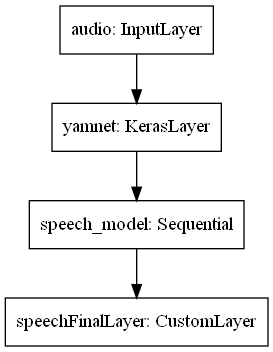

In [36]:
saved_model_path = './model_5'

input_layer = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio') # WAV audio as input
# import the YAMNet model from TF Hub
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle, 
                                            trainable=False, name='yamnet') 
_, embeddings_output, _ = embedding_extraction_layer(input_layer) # extract embeddings (suppress the classification, mel_spectrogram output of YAMNet)
model_outputs = speech_model(embeddings_output) # embeddings to my model, to get binary classfier
#serving_outputs = ReduceMeanLayer(axis=0, name='speechDetector')(serving_outputs)
model_outputs = CustomLayer(name='speechFinalLayer')(model_outputs)
#model_outputs = tf.argmax(model_outputs, axis=1)
export_model = tf.keras.Model(input_layer, model_outputs) 
export_model.save(saved_model_path, include_optimizer=False)

tf.keras.utils.plot_model(export_model)

## Testing the serving model 

In [37]:
load_model = tf.saved_model.load(saved_model_path)


In [38]:
test_wav_data = load_wav_16k_mono('outdoor_test.wav')
result = load_model(test_wav_data)
print(result)

tf.Tensor([0 0 1 0 1], shape=(5,), dtype=int64)
